In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# CATBOOST

In [39]:
df_train = pd.read_csv("train_fNxu4vz.csv")
df_test = pd.read_csv("test_fjtUOL8.csv")

df_train["Loan_Amount_Requested"] = df_train["Loan_Amount_Requested"].str.replace(",", "")
df_train["Loan_Amount_Requested"] = pd.to_numeric(df_train["Loan_Amount_Requested"])
df_test["Loan_Amount_Requested"] = df_test["Loan_Amount_Requested"].str.replace(",", "")
df_test["Loan_Amount_Requested"] = pd.to_numeric(df_test["Loan_Amount_Requested"])

df_train["Length_Employed"].fillna('NaN', inplace=True)
df_test["Length_Employed"].fillna('NaN', inplace=True)

df_train["Home_Owner"].fillna('NaN', inplace=True)
df_test["Home_Owner"].fillna('NaN', inplace=True)

df_train["Income_Verified"].fillna('NaN', inplace=True)
df_test["Income_Verified"].fillna('NaN', inplace=True)

df_train["Purpose_Of_Loan"].fillna('NaN', inplace=True)
df_test["Purpose_Of_Loan"].fillna('NaN', inplace=True)

df_train["Gender"].fillna('NaN', inplace=True)
df_test["Gender"].fillna('NaN', inplace=True)

df_train = df_train.drop(["Loan_ID"], axis=1)
loan_ids = df_test["Loan_ID"].values
df_test = df_test.drop(["Loan_ID"], axis=1)

df_train["Annual_Income"].fillna(df_train["Annual_Income"].mean(), inplace=True)
df_test["Annual_Income"].fillna(df_test["Annual_Income"].mean(), inplace=True)

df_train["Months_Since_Deliquency"].fillna(0, inplace=True)
df_test["Months_Since_Deliquency"].fillna(0, inplace=True)

df_train["Number_Invalid_Acc"] = df_train["Total_Accounts"] - df_train["Number_Open_Accounts"]
df_test["Number_Invalid_Acc"] = df_test["Total_Accounts"] - df_test["Number_Open_Accounts"]

df_train["Number_Years_To_Repay_Debt"] = df_train["Loan_Amount_Requested"]/df_train["Annual_Income"]
df_test["Number_Years_To_Repay_Debt"] = df_test["Loan_Amount_Requested"]/df_test["Annual_Income"]

df_train.head()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate,Number_Invalid_Acc,Number_Years_To_Repay_Debt
0,7000,< 1 year,Rent,68000.000000,not verified,car,18.37,0,0.0,9,14,Female,1,5,0.102941
1,30000,4 years,Mortgage,73331.159434,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3,12,0.409103
2,24725,7 years,Mortgage,75566.400000,VERIFIED - income source,debt_consolidation,15.88,0,0.0,12,16,Male,3,4,0.327196
3,16000,< 1 year,NaN,56160.000000,VERIFIED - income source,debt_consolidation,14.34,3,0.0,16,22,Male,3,6,0.284900
4,17000,8 years,Own,96000.000000,VERIFIED - income source,debt_consolidation,22.17,1,0.0,19,30,Female,1,11,0.177083


In [40]:
X_train, Y = df_train.drop(["Interest_Rate"], axis=1).values, df_train["Interest_Rate"].values
X_test = df_test.values

X_train.shape, Y.shape, X_test.shape

((164309, 14), (164309,), (109541, 14))

In [16]:
kfold, scores = KFold(n_splits=5, shuffle=True, random_state=0), list()
for train, test in kfold.split(X_train):
    x_train, x_test = X_train[train], X_train[test]
    y_train, y_test = Y[train], Y[test]
    
    model = CatBoostClassifier(random_state=27, max_depth=6, task_type="GPU", devices="0:1", n_estimators=1000, verbose=500)
    model.fit(x_train, y_train, cat_features=[1, 2, 4, 5, 11])
    preds = model.predict(x_test)
    score = f1_score(y_test, preds, average="weighted")
    scores.append(score)
    print(score)
print("Average: ", sum(scores)/len(scores))

Learning rate set to 0.175594
0:	learn: 1.0646301	total: 26.7ms	remaining: 26.7s
500:	learn: 0.8755885	total: 10.4s	remaining: 10.4s
999:	learn: 0.8406830	total: 21.1s	remaining: 0us
0.533349619004438
Learning rate set to 0.175594
0:	learn: 1.0642171	total: 28.3ms	remaining: 28.3s
500:	learn: 0.8741221	total: 10.2s	remaining: 10.2s
999:	learn: 0.8387737	total: 21.1s	remaining: 0us
0.5343741572061917
Learning rate set to 0.175594
0:	learn: 1.0645684	total: 25.8ms	remaining: 25.8s
500:	learn: 0.8755210	total: 10.8s	remaining: 10.8s
999:	learn: 0.8414134	total: 21.5s	remaining: 0us
0.5336382563188597
Learning rate set to 0.175594
0:	learn: 1.0646968	total: 24ms	remaining: 23.9s
500:	learn: 0.8749741	total: 11s	remaining: 11s
999:	learn: 0.8402085	total: 21.6s	remaining: 0us
0.5305398289647182
Learning rate set to 0.175594
0:	learn: 1.0647386	total: 26.9ms	remaining: 26.9s
500:	learn: 0.8769672	total: 10.9s	remaining: 10.8s
999:	learn: 0.8429741	total: 21.7s	remaining: 0us
0.53270462572738

In [41]:
model = CatBoostClassifier(random_state=27, task_type="GPU", devices="0:1", n_estimators=1000, max_depth=6, verbose=500)
model.fit(X_train, Y, cat_features=[1, 2, 4, 5, 11])
preds1 = model.predict_proba(X_test)

Learning rate set to 0.183772
0:	learn: 1.0630946	total: 29.1ms	remaining: 29s
500:	learn: 0.8802310	total: 11s	remaining: 11s
999:	learn: 0.8498682	total: 22.1s	remaining: 0us


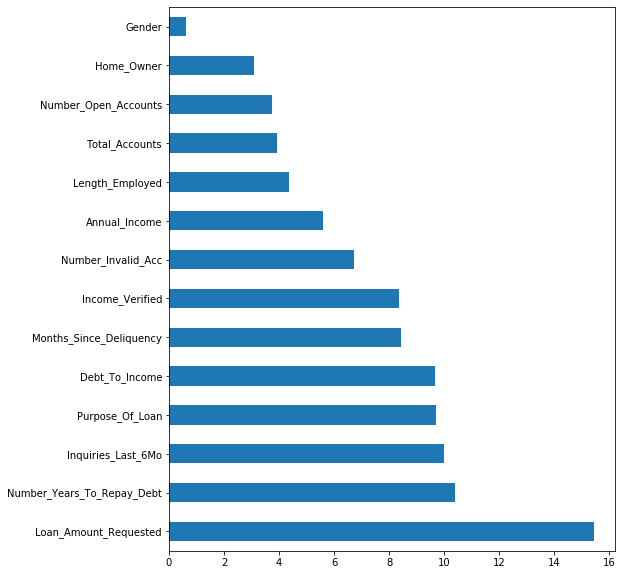

In [42]:
feat_imp = pd.Series(model.feature_importances_, index=df_train.drop(["Interest_Rate"], axis=1).columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

# LIGHTGBM

In [43]:
df_train = pd.read_csv("train_fNxu4vz.csv")
df_test = pd.read_csv("test_fjtUOL8.csv")

df_train["Loan_Amount_Requested"] = df_train["Loan_Amount_Requested"].str.replace(",", "")
df_train["Loan_Amount_Requested"] = pd.to_numeric(df_train["Loan_Amount_Requested"])
df_test["Loan_Amount_Requested"] = df_test["Loan_Amount_Requested"].str.replace(",", "")
df_test["Loan_Amount_Requested"] = pd.to_numeric(df_test["Loan_Amount_Requested"])

df_train["Length_Employed"].fillna('NaN', inplace=True)
df_test["Length_Employed"].fillna('NaN', inplace=True)

df_train["Home_Owner"].fillna('NaN', inplace=True)
df_test["Home_Owner"].fillna('NaN', inplace=True)

df_train["Income_Verified"].fillna('NaN', inplace=True)
df_test["Income_Verified"].fillna('NaN', inplace=True)

df_train["Purpose_Of_Loan"].fillna('NaN', inplace=True)
df_test["Purpose_Of_Loan"].fillna('NaN', inplace=True)

df_train["Gender"].fillna('NaN', inplace=True)
df_test["Gender"].fillna('NaN', inplace=True)

df_train = df_train.drop(["Loan_ID"], axis=1)
loan_ids = df_test["Loan_ID"].values
df_test = df_test.drop(["Loan_ID"], axis=1)

le = LabelEncoder()
df_train["Length_Employed"] = le.fit_transform(df_train["Length_Employed"])
df_test["Length_Employed"] = le.transform(df_test["Length_Employed"])

df_train["Home_Owner"] = le.fit_transform(df_train["Home_Owner"])
df_test["Home_Owner"] = le.transform(df_test["Home_Owner"])

df_train["Income_Verified"] = le.fit_transform(df_train["Income_Verified"])
df_test["Income_Verified"] = le.transform(df_test["Income_Verified"])

df_train["Purpose_Of_Loan"] = le.fit_transform(df_train["Purpose_Of_Loan"])
df_test["Purpose_Of_Loan"] = le.transform(df_test["Purpose_Of_Loan"])

df_train["Gender"] = le.fit_transform(df_train["Gender"])
df_test["Gender"] = le.transform(df_test["Gender"])

df_train["Annual_Income"].fillna(df_train["Annual_Income"].mean(), inplace=True)
df_test["Annual_Income"].fillna(df_test["Annual_Income"].mean(), inplace=True)

df_train["Months_Since_Deliquency"].fillna(0, inplace=True)
df_test["Months_Since_Deliquency"].fillna(0, inplace=True)

df_train["Number_Invalid_Acc"] = df_train["Total_Accounts"] - df_train["Number_Open_Accounts"]
df_test["Number_Invalid_Acc"] = df_test["Total_Accounts"] - df_test["Number_Open_Accounts"]

df_train["Number_Years_To_Repay_Debt"] = df_train["Loan_Amount_Requested"]/df_train["Annual_Income"]
df_test["Number_Years_To_Repay_Debt"] = df_test["Loan_Amount_Requested"]/df_test["Annual_Income"]

df_train.head()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate,Number_Invalid_Acc,Number_Years_To_Repay_Debt
0,7000,10,5,68000.000000,2,0,18.37,0,0.0,9,14,0,1,5,0.102941
1,30000,4,0,73331.159434,0,2,14.93,0,17.0,12,24,0,3,12,0.409103
2,24725,7,0,75566.400000,1,2,15.88,0,0.0,12,16,1,3,4,0.327196
3,16000,10,1,56160.000000,1,2,14.34,3,0.0,16,22,1,3,6,0.284900
4,17000,8,4,96000.000000,1,2,22.17,1,0.0,19,30,0,1,11,0.177083


In [44]:
X_train, Y = df_train.drop(["Interest_Rate"], axis=1).values, df_train["Interest_Rate"].values
X_test = df_test.values

X_train.shape, Y.shape, X_test.shape

((164309, 14), (164309,), (109541, 14))

In [22]:
kfold, scores = KFold(n_splits=5, shuffle=True, random_state=0), list()
for train, test in kfold.split(X_train):
    x_train, x_test = X_train[train], X_train[test]
    y_train, y_test = Y[train], Y[test]
    
    num_class1, num_class2, num_class3 = Counter(y_train)[1], Counter(y_train)[2], Counter(y_train)[3]
    sm = SMOTE(random_state=27, sampling_strategy={1: int(2.0*num_class1), 2: int(1.6*num_class2), 3: int(1.6*num_class3)})
    x_train, y_train = sm.fit_resample(x_train, y_train)
    
    model = LGBMClassifier(random_state=27, max_depth=6, n_estimators=400)
    model.fit(x_train, y_train, categorical_feature=[1, 2, 4, 5, 11])
    preds = model.predict(x_test)
    score = f1_score(y_test, preds, average="weighted")
    scores.append(score)
    print(score)
print("Average: ", sum(scores)/len(scores))

0.5364962372509364
0.5337692541119526
0.5332167074343459
0.5354353011823852
0.5371455480768109
Average:  0.5352126096112861


In [45]:
num_class1, num_class2, num_class3 = Counter(Y)[1], Counter(Y)[2], Counter(Y)[3]
sm = SMOTE(random_state=27, sampling_strategy={1: int(2.0*num_class1), 2: int(1.6*num_class2), 3: int(1.6*num_class3)})
X_train_, Y_ = sm.fit_resample(X_train, Y)

model = LGBMClassifier(random_state=27, max_depth=6, n_estimators=400)
model.fit(X_train_, Y_, categorical_feature=[1, 2, 4, 5, 11])
preds2 = model.predict_proba(X_test)

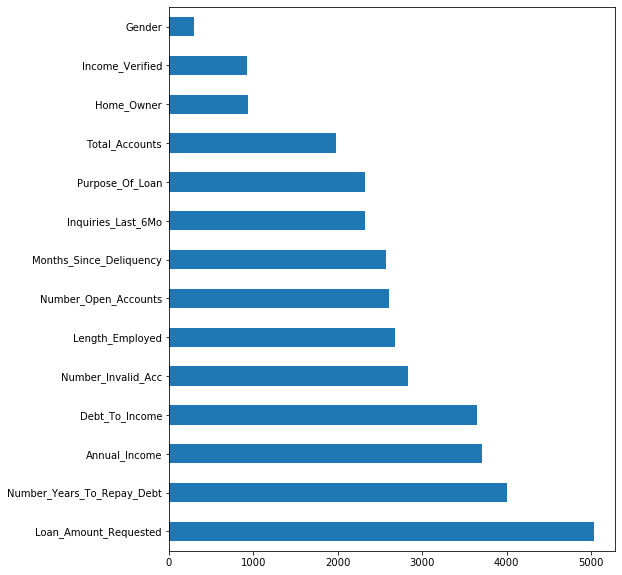

In [46]:
feat_imp = pd.Series(model.feature_importances_, index=df_train.drop(["Interest_Rate"], axis=1).columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

In [47]:
preds = list()
cb_weight=0.4
lb_weight=0.6
for i, j in zip(preds1, preds2):
    xx = [(cb_weight * i[0]) + (lb_weight * j[0]),
          (cb_weight * i[1]) + (lb_weight * j[1]),
          (cb_weight * i[2]) + (lb_weight * j[2])]
    preds.append(xx)
print(preds[:10])
preds=np.argmax(preds,axis=1)+1

[[0.1929159735575896, 0.3840210112179492, 0.42306301522446116], [0.4481615438039259, 0.48065243924181467, 0.07118601695425944], [0.14059423082258893, 0.444006008007065, 0.41539976117034594], [0.1887090753676001, 0.5139598449361376, 0.29733107969626227], [0.0941274969788593, 0.4923881508308, 0.41348435219034063], [0.09547765464866834, 0.49000799035822873, 0.4145143549931029], [0.07591270423612426, 0.3195400534348962, 0.6045472423289796], [0.029110848409458434, 0.11759737054455818, 0.8532917810459834], [0.056943878875617485, 0.2831011962899195, 0.6599549248344629], [0.06606271938637454, 0.3128616824358996, 0.6210755981777258]]


In [48]:
# df_submit = pd.DataFrame({'Loan_ID': loan_ids, 'Interest_Rate': np.argmax(preds2, axis=1)+1})
df_submit = pd.DataFrame({'Loan_ID': loan_ids, 'Interest_Rate': preds})
df_submit.to_csv("submit1.csv", index=False)

In [ ]:
# LGBMClassifier(max_depth=6, n_estimators=400, sampling=2.0,1.6,1.6) CV: 0.5353224096830844 Score: 0.53978150164658
# CatBoostClassifier(n_estimators=5000) CV: 0.5337109747263968 Score: 0.5359361223956677

[[0.17491694170265426, 0.40322054519389505, 0.4218625131034507], [0.44788098803622145, 0.48152933215056115, 0.07058967981321754], [0.16516924074792266, 0.4013672910550343, 0.43346346819704296], [0.1877194351682937, 0.5158027766175108, 0.29647778821419546], [0.1088781750294816, 0.5006676030089275, 0.39045422196159085], [0.09237133855065409, 0.4587732919456884, 0.44885536950365745], [0.07953763177066556, 0.34196379994119, 0.5784985682881445], [0.02378760623259271, 0.1122000357111806, 0.8640123580562267], [0.05736146162540505, 0.2754596080203474, 0.6671789303542475], [0.057428095203973156, 0.33441655262533254, 0.6081553521706943]]